# The Hammurabi simulator 

This tutorial shows how to use the [Hammurabi](https://imagine-code.readthedocs.io/en/latest/imagine.simulators.html#module-imagine.simulators.hammurabi) simulator class the interface to [hammurabiX](https://bitbucket.org/hammurabicode/hamx/src/master/) code.

Throughout the tutorial, we will use the term 'Hammurabi' to refer to 
the Simulator class, and 'hammurabiX' to refer to the hammurabiX software.

In [1]:
import matplotlib
%matplotlib inline

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

import imagine as img

import imagine.observables as img_obs
import astropy.units as u

## Initializing 

In the normal IMAGINE workflow, the simulator produces a set of mock 
observables (Simulators in IMAGINE jargon) which one wants to compare 
with a set of observational data (i.e. Measurements). Thus, the 
Hammurabi simulator class (as any IMAGINE simulator) has to be 
initialized with a Measurements object in order to know properties
of the output it will need to generate.

Therefore, we begin by creating fake, empty, datasets which will help 
instructing Hammurabi which observational data we are interested in.

In [2]:
# Creates some empty fake datasets 
size = 12*32**2 
sync_dset = img_obs.SynchrotronHEALPixDataset(data=np.empty(size)*u.mK, 
                                              frequency=23, type='I')
size = 12*16**2
fd_dset = img_obs.FaradayDepthHEALPixDataset(data=np.empty(size)*u.rad/u.m**2)
size = 12*8**2
dm_dset = img_obs.DispersionMeasureHEALPixDataset(data=np.empty(size)*u.pc/u.cm**3)

# Appends them to an Observables Dictionary
fakeMeasureDict = img.Measurements()
fakeMeasureDict.append(dataset=sync_dset)
fakeMeasureDict.append(dataset=fd_dset)
fakeMeasureDict.append(dataset=dm_dset)

Now it is possible initializing the simulator. Note that Hammurabi 
will also require a template xml file. One example of which can be
found in this tutorials directory.

Once initialized, the Hammurabi simulator prints its setup, showing that we have defined three observables.

In [3]:
base_xml = './template.xml'
simer = img.Hammurabi(measurements=fakeMeasureDict,xml_path=base_xml)

observable {}
|-->  sync {'cue': '1', 'freq': '23', 'nside': '32'}
|-->  faraday {'cue': '1', 'nside': '16'}
|-->  dm {'cue': '1', 'nside': '8'}


## Running with dummy fields

### Using only non-stochastic fields

In order to run an IMAGINE simulator, we need to specify a list of 
Field objects it will map onto observables.

The original hammurabiX code is *not only* a Simulator in IMAGINE's sense, but comes also with a large set of built-in fields. Using 
dummy IMAGINE fields, it is  possible to instruct Hammurabi to run using one of hammurabiX's built-in fields instead of evaluating an
IMAGINE Field.

A range of such dummy Fields and the associated Field Factories can be found in the subpackage [imagine.fields.hamx](https://imagine-code.readthedocs.io/en/latest/imagine.fields.hamx.html). 

Using some of these, let us initialize three dummy fields: one instructing Hammurabi to use one of hammurabiX's regular fields (`BregLSA`), one setting CR electron distribution (`CREAna`), 
and one setting the thermal electron distribution (`YMW16`).

In [4]:
from imagine.fields.hamx.breg_lsa import BregLSA
from imagine.fields.hamx.cre_analytic import CREAna
from imagine.fields.hamx.tereg_ymw16 import TEregYMW16

## ensemble size
ensemble_size = 2

## Set up the BregLSA field with the parameters you want:
paramlist = {'b0': 6.0, 'psi0': 27.9, 'psi1': 1.3, 'chi0': 24.6}
breg_wmap = BregLSA(parameters=paramlist, ensemble_size=ensemble_size)

## Set up the analytic CR model CREAna 
paramlist = {'alpha': 3.0, 'beta': 0.0, 'theta': 0.0,
             'r0': 5.6, 'z0': 1.2,
             'E0': 20.5,
             'j0': 0.03}
cre_ana = CREAna(parameters=paramlist, ensemble_size=ensemble_size)

##  The free electron model based on YMW16, ie. TEregYMW16 
paramlist = {} # This has no parameters
fereg_ymw16 = TEregYMW16(parameters=paramlist, ensemble_size=ensemble_size)

Now we can run the Hammurabi to generate one set of observables

In [5]:
maps = simer([breg_wmap, cre_ana, fereg_ymw16])

The `Hammurabi` class wraps around hammurabiX's own python wrapper `hampyx`.  The latter can be accessed through the attribue
`_ham`.

It is generally convenient not using `hampyx` directly, considering future updates in hammurabiX. Nevertheless, there situations where 
this is still convenient, particularly while troubleshooting.

The direct access to `hampyx` is exemplified below, where we check its initialization, after running the simulation object.

In [6]:
simer._ham.print_par(['magneticfield', 'regular'])
simer._ham.print_par(['magneticfield', 'regular', 'wmap'])
simer._ham.print_par(['cre'])
simer._ham.print_par(['cre', 'analytic'])
simer._ham.print_par(['thermalelectron', 'regular'])

regular {'cue': '1', 'type': 'lsa'}
|-->  lsa {}
|-->  jaffe {}
|-->  unif {}
cre {'cue': '1', 'type': 'analytic'}
|-->  analytic {}
|-->  unif {}
analytic {}
|-->  alpha {'value': '3.0'}
|-->  beta {'value': '0.0'}
|-->  theta {'value': '0.0'}
|-->  r0 {'value': '5.6'}
|-->  z0 {'value': '1.2'}
|-->  E0 {'value': '20.5'}
|-->  j0 {'value': '0.03'}
regular {'cue': '1', 'type': 'ymw16'}
|-->  ymw16 {}
|-->  unif {}


Any `Simulator` by convention returns a `Simulations` object, which collect all required maps.  We want to get them back as arrays we can visualize with healpy.  The `data` attribute does this, and note that what it gets back is a **list** of two of each type of observable, since we specified `ensemble_size=2` above.  But since we have not yet added a random component, they are both the same:  

In [7]:
maps[('sync','23','32','I')].data

array([[0.08884023, 0.08772291, 0.08634578, ..., 0.08866684, 0.08728929,
        0.08849186],
       [0.08884023, 0.08772291, 0.08634578, ..., 0.08866684, 0.08728929,
        0.08849186]])

Bellow we exemplify how to extract and plot the simulated maps produced by Hammurabi:

/home/lfsr/.local/lib/python3.7/site-packages/healpy-1.12.8-py3.7-linux-x86_64.egg/healpy/projaxes.py:989: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/lfsr/.local/lib/python3.7/site-packages/healpy-1.12.8-py3.7-linux-x86_64.egg/healpy/projaxes.py:959: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


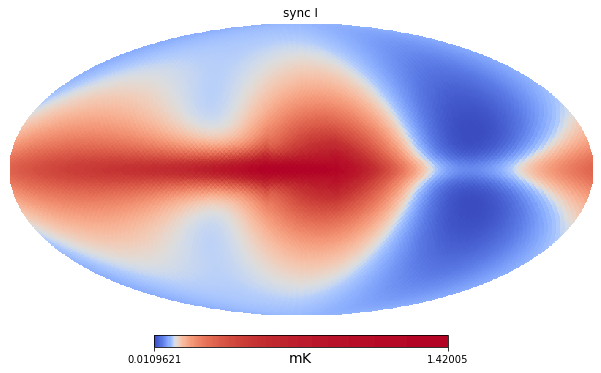

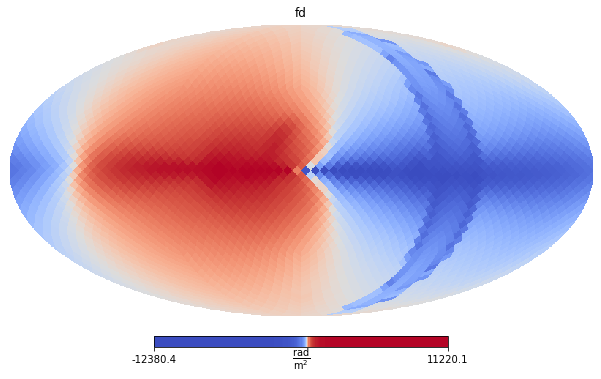

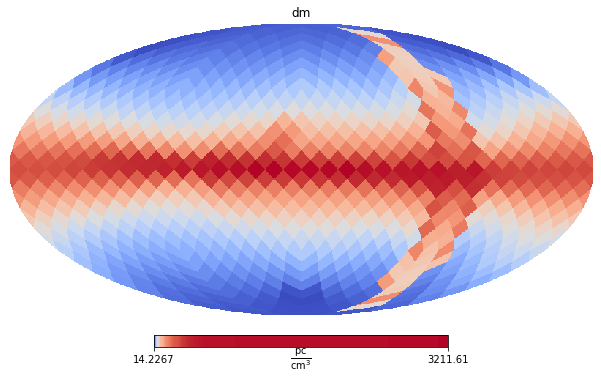

In [8]:
for key in maps.keys():
    simulated_data = maps[key].data[0]
    simulated_unit = maps[key].unit
    name = key[0]
    if key[3] != 'nan':
        name += ' '+key[3]
    hp.mollview(simulated_data, norm='hist', cmap='coolwarm',
                unit=simulated_unit._repr_latex_(), title=name)

### Using a stochastic magnetic field component

Now we add a random GMF component with the BrndES model.  This model starts with a random number generator to simulate a Gaussian random field on a cartesian grid and ensures that it is divergence free.  The grid is defined in hammurabiX XML parameter file.  

In [9]:
## Modify the random field grid for limiting the notebook's memory consumption.
simer._ham.mod_par(['grid', 'box_brnd', 'nx'], {'value': '100'})
simer._ham.mod_par(['grid', 'box_brnd', 'ny'], {'value': '100'})
simer._ham.mod_par(['grid', 'box_brnd', 'nz'], {'value': '20'})

In [10]:
from imagine.fields.hamx.brnd_es import BrndES

paramlist = {'rms': 6., 'k0': 0.5, 'a0': 1.7, 
             'k1': 0.5, 'a1': 0.0,
             'rho': 0.5, 'r0': 8., 'z0': 1.}
brnd_es = BrndES(parameters=paramlist, ensemble_size=ensemble_size)

Now use the simulator to generate the maps from these field components and visualize:

In [11]:
maps = simer([breg_wmap, brnd_es, cre_ana, fereg_ymw16])

In [12]:
print(maps.keys())

dict_keys([('sync', '23', '32', 'I'), ('fd', 'nan', '16', 'nan'), ('dm', 'nan', '8', 'nan')])


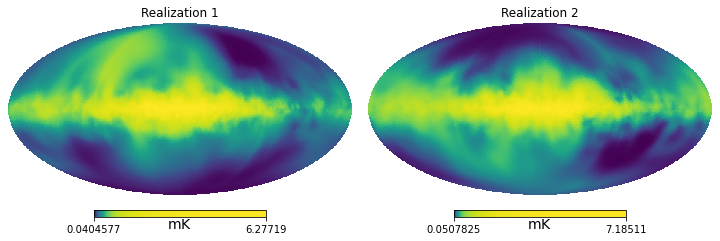

In [13]:
sync_I_data = maps[('sync','23','32','I')].data
sync_I_units = maps[('sync','23','32','I')].unit

matplotlib.rcParams['figure.figsize'] = (10.0, 4.0)
for i in range(1,3):
    hp.mollview(sync_I_data[i-1], norm='hist',sub=(1,2,i),
                unit=sync_I_units._repr_latex_(), title='Realization {}'.format(i))